In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [2]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [3]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

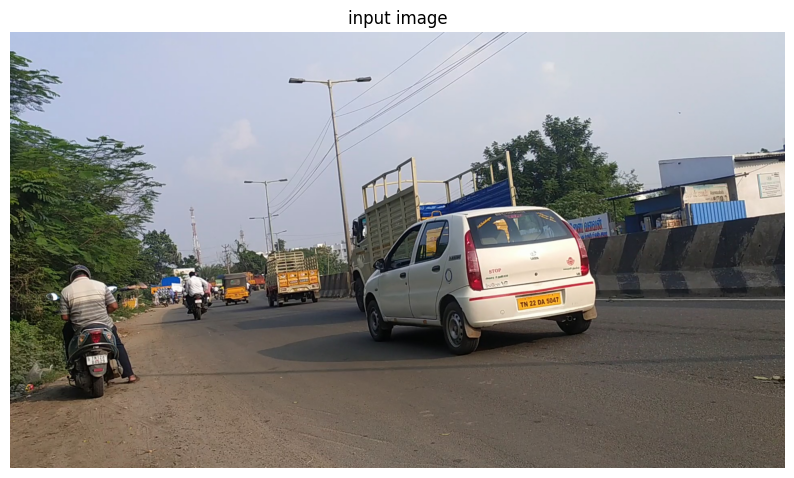

In [4]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('car.jpg')
display(img, 'input image')

### Model for characters

In [5]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [6]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [7]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])


c:\users\datapoint\appdata\local\programs\python\python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [9]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [10]:
batch_size = 1
callbacks = [stop_training_callback()]
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

C:\Users\datapoint\AppData\Local\Temp\ipykernel_14084\4053693827.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80
864/864 [==============================] - 77s 88ms/step - loss: 2.9942 - custom_f1score: 0.1667 - val_loss: 2.0335 - val_custom_f1score: 0.4122
Epoch 2/80
864/864 [==============================] - 76s 87ms/step - loss: 1.2607 - custom_f1score: 0.6181 - val_loss: 0.6515 - val_custom_f1score: 0.7530
Epoch 3/80
864/864 [==============================] - 77s 89ms/step - loss: 0.6072 - custom_f1score: 0.7998 - val_loss: 0.3189 - val_custom_f1score: 0.8750
Epoch 4/80
864/864 [==============================] - 76s 88ms/step - loss: 0.3623 - custom_f1score: 0.8796 - val_loss: 0.2703 - val_custom_f1score: 0.9241
Epoch 5/80
864/864 [==============================] - 75s 87ms/step - loss: 0.3758 - custom_f1score: 0.8843 - val_loss: 0.1162 - val_custom_f1score: 0.9821
Epoch 6/80
864/864 [==============================] - 75s 87ms/step - loss: 0.2344 - custom_f1score: 0.9225 - val_loss: 0.1095 - val_custom_f1score: 0.9673
Epoch 7/80
864/864 [==============================] - 76s 88ms/s

In [11]:
# https://www.kaggle.com/code/sarthakvajpayee/license-plate-recognition-using-cnn

In [12]:
model.save("MyModel.h5")

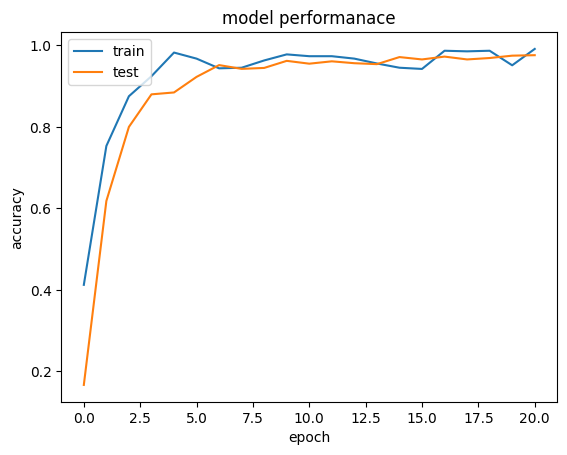

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_custom_f1score'])
plt.plot(history.history['custom_f1score'])
plt.title('model performanace')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()